In [230]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import seaborn
import plotly.express as px
plt.style.use('fivethirtyeight')

import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

In [2]:
#creates connection to mongodb
client = pymongo.MongoClient()
db = client.tweeter

In [88]:
bernie_coll = db.bernie_tweets
joe_coll = db.joe_tweets
pete_coll = db.pete_tweets
warren_coll = db.warren_tweets
amy_coll = db.amy_tweets

In [89]:
#retrieved data from mongo into a dataframe
bernie_df = pd.DataFrame(list(bernie_coll.find()))
joe_df = pd.DataFrame(list(joe_coll.find()))
pete_df = pd.DataFrame(list(pete_coll.find()))
warren_df = pd.DataFrame(list(warren_coll.find()))
amy_df = pd.DataFrame(list(amy_coll.find()))

In [203]:
b_df = bernie_df[~bernie_df['text'].isnull()]

In [217]:
df = b_df.set_index('date')
df.index = pd.to_datetime(df.index)
df['year'] = df.index.year
df['month'] = df.index.month
df['wk_name'] = df.index.weekday_name

In [220]:
df[df['year'] == 2019]

,_id,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink,year,month,wk_name
date,,,,,,,,,,,,,,,
2019-12-31 21:10:32,5e544761137a410232c179ae,BernieSanders,NaN,585,1997,11171,We cannot continue to act as though it is norm...,NaN,NaN,NaN,1212118865867681799,https://twitter.com/BernieSanders/status/12121...,2019,12,Tuesday
2019-12-31 19:11:16,5e544761137a410232c179af,BernieSanders,NaN,1019,1757,7412,Everybody who knows me knows I hate asking for...,NaN,NaN,NaN,1212088853869334528,https://twitter.com/BernieSanders/status/12120...,2019,12,Tuesday
2019-12-31 18:38:11,5e544761137a410232c179b0,BernieSanders,NaN,297,2186,12342,Don't let anyone tell you that you cannot make...,NaN,NaN,NaN,1212080526317834240,https://twitter.com/BernieSanders/status/12120...,2019,12,Tuesday
2019-12-31 18:06:52,5e544761137a410232c179b1,BernieSanders,NaN,169,665,2500,"Friends, we are closing in our goal of 5 milli...",NaN,NaN,NaN,1212072647103631361,https://twitter.com/BernieSanders/status/12120...,2019,12,Tuesday
2019-12-31 17:14:03,5e544761137a410232c179b2,BernieSanders,NaN,163,564,2250,If you would like to make the pharmaceutical i...,NaN,NaN,NaN,1212059352393289729,https://twitter.com/BernieSanders/status/12120...,2019,12,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01 23:18:44,5e544761137a410232c18628,BernieSanders,NaN,560,1627,8313,If we are serious about reducing income and we...,NaN,NaN,NaN,1080241945895682048,https://twitter.com/BernieSanders/status/10802...,2019,1,Tuesday
2019-01-01 22:04:46,5e544761137a410232c18629,BernieSanders,NaN,341,1205,6098,We must end the absurdity of the United States...,NaN,NaN,NaN,1080223333478776832,https://twitter.com/BernieSanders/status/10802...,2019,1,Tuesday
2019-01-01 21:06:04,5e544761137a410232c1862a,BernieSanders,NaN,1230,2378,10913,"As Frederick Douglass reminded us: ""If there i...",NaN,NaN,NaN,1080208558736723968,https://twitter.com/BernieSanders/status/10802...,2019,1,Tuesday


In [210]:
df['year'] = df.index.year
df['month'] = df.index.month
df['wk_name'] = df.index.weekday_name

AttributeError: 'Index' object has no attribute 'year'

In [267]:
def sentiment_analyser(df):
    n_df = df[~df['text'].isnull()]

    sentiment_objects = [TextBlob(tweet) for tweet in n_df['text']]
    # Create list of polarity valuesx and tweet text
    sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]
    # Create dataframe containing the polarity value and tweet text
    sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

    sent_df = n_df.merge(sentiment_df, left_on='text', right_on='tweet')
    
    output_df = sent_df.set_index('date')
    output_df.index = pd.to_datetime(output_df.index)
    output_df['year'] = output_df.index.year
    output_df['month'] = output_df.index.month
    output_df['wk_name'] = output_df.index.weekday_name
    
    return output_df

In [214]:
def plot_sentiment(df):
    #plot data
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot histogram of the polarity values
    sentiment_df.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                            0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
                 ax=ax,
                 color="purple")

    plt.title(title)
    return plt.show()

In [268]:
bernie_sentiment = sentiment_analyser(bernie_df)

In [274]:
pol = bernie_sentiment[(bernie_sentiment['year']==2020)&(bernie_sentiment['month']==2)]['polarity']

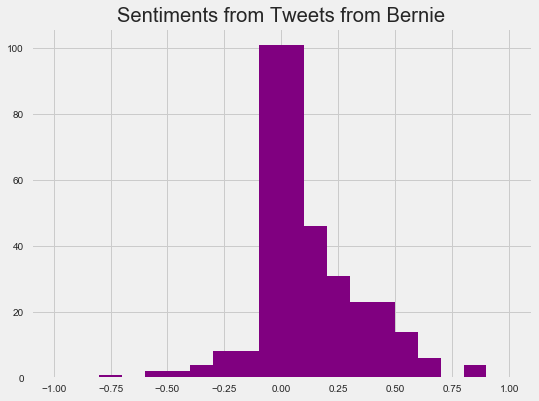

In [275]:
def polarity_bydate(df, yr, mm, dd):
    
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot histogram of the polarity values
    pol.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                            0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
                 ax=ax,
                 color="purple")

    plt.title("Sentiments from Tweets from Bernie")
    return plt.show()

In [11]:
sentiment_objects = [TextBlob(tweet) for tweet in b_df['text']]

In [12]:
# Create list of polarity valuesx and tweet text
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

In [13]:
# Create dataframe containing the polarity value and tweet text
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

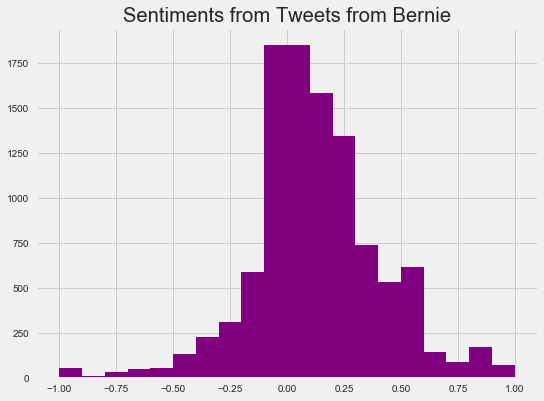

In [231]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
sentiment_df.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                        0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets from Bernie")
plt.show()

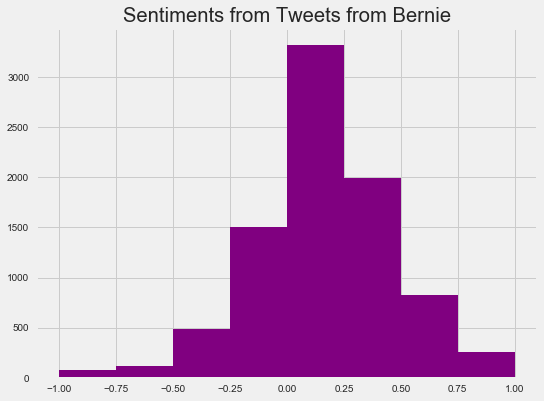

In [236]:
# Remove polarity values equal to zero
sentiment_df = sentiment_df[sentiment_df.polarity != 0]
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets from Bernie")
plt.show()

In [17]:
sentiment_df.sort_values(by='polarity')

,polarity,tweet
862,-1.0,The outrageous abuse taking place at Glenwood ...
6719,-1.0,I condemn the horrific terrorist attack in Jer...
9125,-1.0,What an outrageous and bigoted statement. @rea...
2001,-1.0,Our health care system is cruel and barbaric. ...
4668,-1.0,"My thoughts are with the people of Barcelona, ..."
...,...,...
8492,1.0,Congrats to Kappa Alpha Psi Inc. on 105 years ...
3445,1.0,We set a goal of 1 million donations not becau...
6925,1.0,We need your help today to win Wisconsin! Make...
12644,1.0,#Filibernie's Greatest Hits http://motherjones...


In [200]:
sent_df = b_df.merge(sentiment_df, left_on='text', right_on='tweet')

In [52]:
bern_df = b_df.set_index('date')

In [58]:
bern_df.index = pd.to_datetime(bern_df.index)

In [77]:
bern_df.head()

,_id,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink,year,month,wk_name
date,,,,,,,,,,,,,,,
2020-02-23 23:08:28,5e544761137a410232c1773e,BernieSanders,NaN,1025,3705,23609,"We won the popular vote in Iowa, we won the Ne...",NaN,NaN,NaN,1231717490742292480,https://twitter.com/BernieSanders/status/12317...,2020,2,Sunday
2020-02-23 23:04:57,5e544761137a410232c1773f,BernieSanders,NaN,371,956,4533,"This campaign has the momentum to win, but we ...",NaN,NaN,NaN,1231716605622657025,https://twitter.com/BernieSanders/status/12317...,2020,2,Sunday
2020-02-23 22:34:47,5e544761137a410232c17740,BernieSanders,NaN,1047,5017,44742,"As president, I will support the rights of bot...",NaN,NaN,NaN,1231709011688480768,https://twitter.com/BernieSanders/status/12317...,2020,2,Sunday
2020-02-23 22:34:46,5e544761137a410232c17741,BernieSanders,NaN,4042,15101,97230,The Israeli people have the right to live in p...,NaN,NaN,NaN,1231709010430189570,https://twitter.com/BernieSanders/status/12317...,2020,2,Sunday
2020-02-23 20:20:37,5e544761137a410232c17742,BernieSanders,NaN,6105,9230,63002,Trump and his friends think they're going to w...,NaN,NaN,NaN,1231675250963832833,https://twitter.com/BernieSanders/status/12316...,2020,2,Sunday


In [61]:
bern_df['year'] = bern_df.index.year
bern_df['month'] = bern_df.index.month
bern_df['wk_name'] = bern_df.index.weekday_name

In [ ]:
[TextBlob(tweet) for tweet in bern_df['text']]

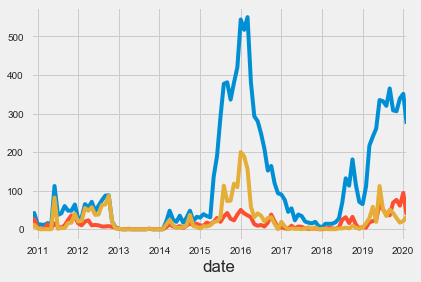

In [237]:
bern_df.resample('M')['text'].count().plot()
bern_df.resample('M')['mentions'].count().plot()
bern_df.resample('M')['hashtags'].count().plot()
plt.show()

In [70]:
def polyplot(df):
    n_df = df[~df['text'].isnull()]
    show_df = n_df.set_index('date')
    show_df.index = pd.to_datetime(show_df.index)

    show_df.resample('M')['text'].count().plot()
    show_df.resample('M')['mentions'].count().plot()
    return plt.show()

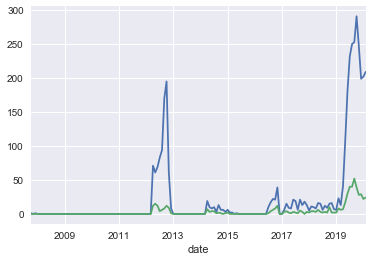

In [71]:
polyplot(joe_df)

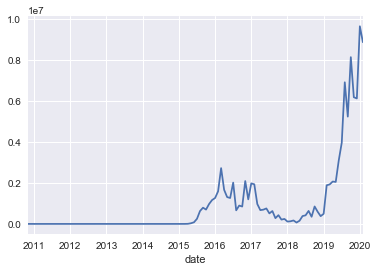

In [74]:
bern_df.resample('M')['favorites'].sum().plot()
plt.show()

In [75]:
bern_df.resample('M')['favorites'].sum()

date
2010-11-30        120
2010-12-31        105
2011-01-31          8
2011-02-28         15
2011-03-31          3
               ...   
2019-10-31    8135165
2019-11-30    6179098
2019-12-31    6118637
2020-01-31    9640608
2020-02-29    8863625
Freq: M, Name: favorites, Length: 112, dtype: int64

In [184]:
def polyplot(df, rate='M'):
    n_df = df[~df['text'].isnull()]
    show_df = n_df.set_index('date')
    show_df.index = pd.to_datetime(show_df.index)
    return show_df.resample(rate)['text'].count()

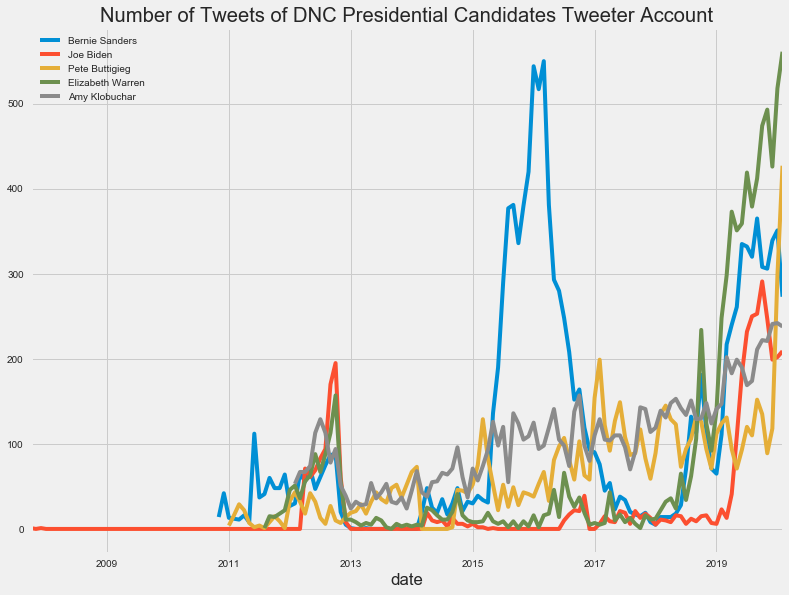

In [238]:
fig, ax = plt.subplots(figsize=(12,9))
polyplot(bernie_df).plot()
polyplot(joe_df).plot()
polyplot(pete_df).plot()
polyplot(warren_df).plot()
polyplot(amy_df).plot()
labels = ['Bernie Sanders', 'Joe Biden', 'Pete Buttigieg', 'Elizabeth Warren ', 'Amy Klobuchar']
plt.legend(labels)
plt.title('Number of Tweets of DNC Presidential Candidates Tweeter Account')
plt.show()

In [239]:
data = pd.concat([polyplot(bernie_df, rate='D'),polyplot(joe_df, rate='D'), 
                  polyplot(pete_df, rate='D'), polyplot(warren_df, rate='D'),
                  polyplot(amy_df, rate='D')], axis=1)

cols=['bernie', 'joe', 'pete', 'warren', 'amy']
data.columns = cols

In [244]:
def plot_trend(x, y):
    title = "{} Tweets Trends".format(y.capitalize())
    fig=px.line(data, x=x, y=y, title=title)
    return fig.show()

In [245]:
plot_trend(data.index, 'warren')
plot_trend(data.index, 'joe')